# Lets start off by performing similarity search for images

In [1]:
import numpy as np
import imageio
from skimage import transform
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib notebook

In [2]:
# Looking at 3 different golden retriever pups (Google images found these to be similar)
def load_image(img_path, resize=True):
    tmp_img = imageio.imread(img_path)
    if resize:
        return transform.resize(image=tmp_img,output_shape=(200,200))
    return tmp_img

In [3]:
img1 = load_image("data/images/golden1.jpg")
img2 = load_image("data/images/golden2.jpg")
img3 = load_image("data/images/golden3.jpg")

/home/hemant/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/hemant/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


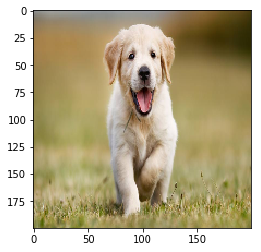

In [4]:
plt.imshow(img1)

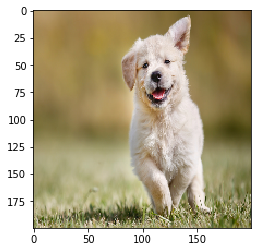

In [5]:
plt.imshow(img2)

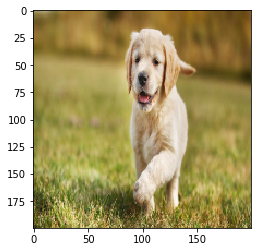

In [6]:
plt.imshow(img3)

In [7]:
def mse_image(image1,image2):
    return sqrt(np.mean((image1-image2)**2))

In [8]:
print(mse_image(img1,img2))
print(mse_image(img2,img3))
print(mse_image(img3,img1))

0.1962357982166263
0.19501462044352869
0.1865044091397436


In [9]:
from skimage.measure import compare_ssim as ssim

In [10]:
print(ssim(img1,img2,multichannel=True))
print(ssim(img2,img3,multichannel=True))
print(ssim(img3,img1,multichannel=True))

0.5443769054769791
0.5124492905555901
0.502516321833674


/home/hemant/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


We know that `SSIM` (Structural Similarity) is robust to noise and contrast changes unlike `MSE` (Mean Square Error)

In [11]:
# MSE is faster than SSIM
%timeit mse_image(img1,img2)
%timeit ssim(img1,img2,multichannel=True)

124 µs ± 6.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.12 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For the $200\times200$ image, the MSE took 130 $\mu$s while SSIM took 6.68 ms i.e. MSE was $50\times$ faster.

# Dominant color

In [12]:
import dominant_cluster
%timeit dcolors = dominant_cluster.get_dom_colors("data/images/golden1.jpg",clusters=10)

18.2 s ± 1.81 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
import kmeans_gpu
%timeit dcolors, bar_img = kmeans_gpu.run("data/images/golden1.jpg",clusters=10)
!nvidia-smi

/home/hemant/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/hemant/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


281 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Wed Nov  7 11:55:54 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   65C    P2    26W /  N/A |   1494MiB /  6078MiB |     50%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:        

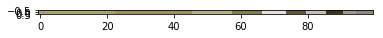

In [15]:
dcolors, bar_img = kmeans_gpu.run("data/images/golden1.jpg",clusters=10)
plt.imshow(bar_img)

We get such a $1\times100$ image for each of the images we cluster i.e. we cluster a resized image of size $200\times200$ and create a smaller image of size $100$ ($0.25\%$) that contains its dominant colors in descending order of dominance. 

The next step is to concatenate these 100 pixel images for each frame (samples at $n$ fps from the video of length $l$ seconds) to create a new image of size $l\times n \times100$ pixel image that will represent the entire video.

This compressed image representation is thereafter used to find similar images using either the **MSE** or **SSIM** similarity metric or by using the **KNN** algorithm.